In [13]:
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.types import PolygonAnnotation as Polygon
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

import cv2

from py.helpers import get_outlines, get_area, get_patch, get_sub_areas, patch_empty, concat_one, BARRET_ROOT
import os

os.add_dll_directory(r'C:\Program Files\openslide-win64\bin') # for openslide

LANS_DIR = os.path.join(BARRET_ROOT, 'LANS_001-923')
LANS_BIOP_ROOT = os.path.join(BARRET_ROOT, 'p53_experiment_luuk_biopsy-level_no-HE')
LANS_BIOP_DIR = os.path.join(LANS_BIOP_ROOT, 'P53_score_high_consensus')
BOLERO_DIR = os.path.join(BARRET_ROOT, 'BOLERO', 'P53 Bolero')
PATHXL_DIR = os.path.join(LANS_BIOP_ROOT, 'final_test_set_(low_consensus_second_look)', 'not_ready', 'pathxl')

In [14]:
d = LANS_BIOP_DIR
tiffs = [f for f in os.listdir(d) if f.endswith('.tiff')]
xmls = [f for f in os.listdir(d) if f.endswith('.xml')]
print(f'{d}: {len(tiffs)} tiffs, {len(xmls)} xmls')

xml_names = [f.split('.')[0] for f in xmls]
tiff_names = [f.split('.')[0] for f in tiffs]

# Find the names that are in both lists
both = set(xml_names).intersection(set(tiff_names))
print(f'Both: {len(both)}')

casenames = sorted(list(both))


d = BOLERO_DIR
tiffs = [f for f in os.listdir(d) if f.endswith('.tiff')]
xmls = [f for f in os.listdir(d) if f.endswith('.xml')]
print(f'{d}: {len(tiffs)} tiffs, {len(xmls)}')

xml_names = [f.split('.')[0] for f in xmls]
tiff_names = [f.split('.')[0] for f in tiffs]

# Find the names that are in both lists
both = set(xml_names).intersection(set(tiff_names))
print(f'Both: {len(both)}')

casenames_BOLERO = sorted(list(both))


d = PATHXL_DIR
tiffs = [f for f in os.listdir(d) if f.endswith('.tiff')]
xmls = [f for f in os.listdir(d) if f.endswith('.xml')]
print(f'{d}: {len(tiffs)} tiffs, {len(xmls)}')

xml_names = [f.split('.')[0] for f in xmls]
tiff_names = [f.split('.')[0] for f in tiffs]

# Find the names that are in both lists
both = set(xml_names).intersection(set(tiff_names))
print(f'Both: {len(both)}')

casenames_PATHXL = sorted(list(both))

L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_experiment_luuk_biopsy-level_no-HE\P53_score_high_consensus: 442 tiffs, 442 xmls
Both: 442
L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\BOLERO\P53 Bolero: 55 tiffs, 55
Both: 55
L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_experiment_luuk_biopsy-level_no-HE\final_test_set_(low_consensus_second_look)\not_ready\pathxl: 161 tiffs, 166
Both: 161


In [15]:
def get_all_annotated_cases(dir):
    filepaths = {f.split('.')[0]:{"wsi":None, "wsa":None} for f in os.listdir(dir)}
    for f in os.listdir(dir):
        case = f.split('.')[0]

        if ".tiff" in f:
            typ = "wsi"
        elif f.endswith(".xml"):
            typ = "wsa"
        else:
            continue

        filepaths[case][typ] = os.path.join(dir, f)
    return filepaths

In [16]:
cases = get_all_annotated_cases(LANS_BIOP_DIR)
cases_BOLERO = get_all_annotated_cases(BOLERO_DIR)
cases_PATHXL = get_all_annotated_cases(PATHXL_DIR)

In [5]:
def plot_sub_areas(wsi, sub_areas, area_labels=[], save_path="", spacing=2.0, figsize_factor=2, show_emptiness=False):
    nrows = len(sub_areas)
    ncols = len(sub_areas[0])
    fig, ax = plt.subplots(nrows,ncols, figsize=(ncols*figsize_factor,nrows*figsize_factor))
    for i in range(nrows):
        for j in range(ncols):
            if ncols < 2:
                index = i
            else:
                index = (i,j)

            if j < len(sub_areas[i]):
                sub_area = sub_areas[i][j]
                sub_patch = wsi.get_patch(*sub_area, spacing)
                
                # color = "red" if sub_patch.mean() < 10 else "black"
                # ax[i,j].text(105,128, f"{sub_patch.std():.2f}", c=color)
                if show_emptiness:
                    color = "red" if sub_patch.mean() > 223 else "black"
                    ax[index].text(105,128, f"{sub_patch.mean():.2f}", c=color)
                if len(area_labels) > 0:
                    ax[index].set_title(area_labels[i*ncols+j])
                ax[index].imshow(sub_patch)

            ax[index].axis("off")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close(fig)


# def save_all_sub_areas_plots(spacing, root=ROOT):
#     for casename, case in tqdm(get_all_annotated_cases(root).items()):
#         for coupe, paths in case.items():
#             outlines = get_outlines(WholeSlideAnnotation(paths["wsa"]))
#             for biopsy_nr, outline in enumerate(outlines):
#                 plot_sub_areas(
#                     WholeSlideImage(paths["wsi"]), 
#                     get_sub_areas(get_area(outline, spacing), spacing=spacing), 
#                     save_path=os.path.join(ROOT, "visualisation", f"sub_areas_{casename}_{biopsy_nr}_{coupe}.png"),
#                     spacing=spacing)

# save_all_sub_areas_plots(2, root=ROOT_ADJACENT)

Example of patching

RBE-00101-P53-I


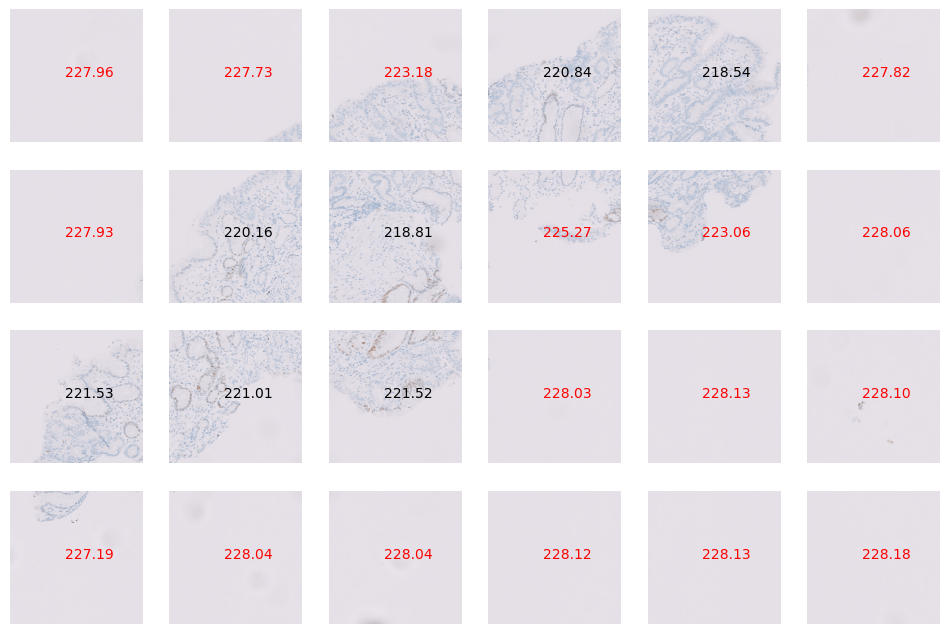

In [6]:
spacing = 2.0

d = LANS_BIOP_DIR
casename = casenames[0]
print(casename)
casepaths = cases[casename]
outlines = get_outlines(WholeSlideAnnotation(casepaths["wsa"])) # biopsy outlines
area = get_area(outlines[0], spacing) # biopsy area
sub_areas = get_sub_areas(area) # sub areas (patches) of biopsy area
wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
plot_sub_areas(wsi, sub_areas, show_emptiness=True)

Example of showing biopsies

Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_experiment_luuk_biopsy-level_no-HE\P53_score_high_consensus
Case:  RBE-00106-P53-I


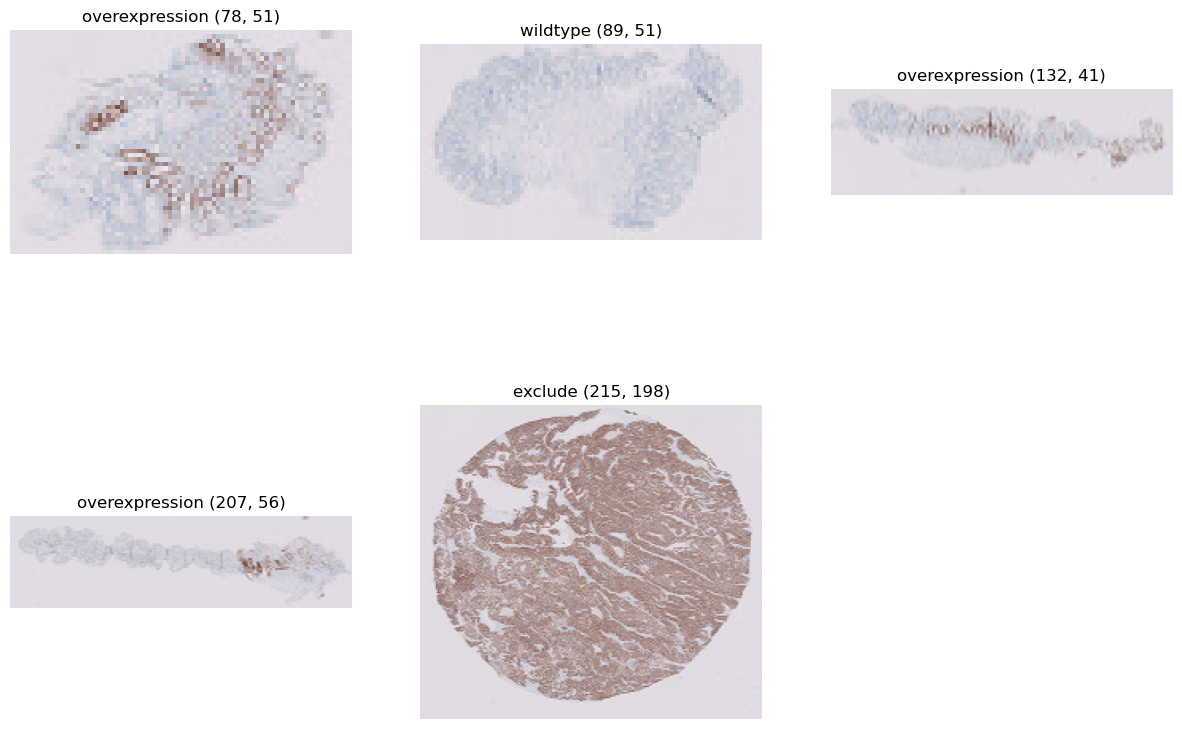

In [7]:
spacing = 32.0

d = LANS_BIOP_DIR
casename = casenames[5]
print("Dir: ", d)
print("Case: ", casename)
casepaths = cases[casename]
wsa = WholeSlideAnnotation(casepaths["wsa"])

labels = [a.label.name for a in wsa.annotations] # biopsy labels

outlines = get_outlines(wsa) # biopsy outlines
areas = [get_area(outline, spacing) for outline in outlines] # biopsy areas
# Append labels with (width, height) of biopsy
labels = [f"{label} ({int(area[2])}, {int(area[3])})" for label, area in zip(labels, areas)]
half_areas_len = int(np.ceil(len(areas)/2))
areas = [[a for a in areas[:half_areas_len]], [a for a in areas[half_areas_len:]]]
wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
plot_sub_areas(wsi, areas, figsize_factor=5, area_labels=labels, spacing=spacing)

Gather data on biopsies

In [8]:
CREATE_DATASET = False

In [15]:
# spacing = 0.5
spacing  = 32.0

if not CREATE_DATASET:
    biopsies = {}

    d = LANS_BIOP_DIR
    print("Dir: ", d)
    for casename in tqdm(casenames):    
        casepaths = cases[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        labels = [a.label.name for a in wsa.annotations] # biopsy labels

        outlines = get_outlines(wsa) # biopsy outlines

        for b in range(len(labels)):
            outline = outlines[b]
            area = get_area(outline, spacing)

            biopsies[f"{casename}_b{b}"] = {
                "dir": d.split("\\")[-1],
                "casename": casename,
                "height": int(area[2]),
                "width": int(area[3]),
                "label": labels[b],
            }


Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_experiment_luuk_biopsy-level_no-HE\P53_score_high_consensus


100%|██████████| 425/425 [00:06<00:00, 64.44it/s]


Analyze biopsy distribution

Largest biopsy: 21376 x 19328	wildtype	413,155,328 pixels at 0.25 m/p

5344 x 4832	wildtype	25,822,208 at 1.0 m/p

,dir,casename,height,width,label,pixels
RL353_RT19-60738_P53_I-1_b1,P53_score_high_consensus,RL353_RT19-60738_P53_I-1,167,150,wildtype,25050
RL093_01_03_01_P53 (2)_b1,P53_score_high_consensus,RL093_01_03_01_P53 (2),97,216,wildtype,20952
RL115_01_01_01_P53_b1,P53_score_high_consensus,RL115_01_01_01_P53,152,132,overexpression,20064
RL119_01_03_01_P53_b1,P53_score_high_consensus,RL119_01_03_01_P53,122,164,wildtype,20008
RL093_01_03_01_P53_b1,P53_score_high_consensus,RL093_01_03_01_P53,86,223,wildtype,19178
...,...,...,...,...,...,...
RL028_01_04_01_P53_b1,P53_score_high_consensus,RL028_01_04_01_P53,36,23,wildtype,828
RL250_01_03_01_P53_1_b2,P53_score_high_consensus,RL250_01_03_01_P53_1,23,35,wildtype,805
RL036_01_02_01_P53_b2,P53_score_high_consensus,RL036_01_02_01_P53,20,40,overexpression,800
RL024_01_05_01_P53_b3,P53_score_high_consensus,RL024_01_05_01_P53,29,27,wildtype,783


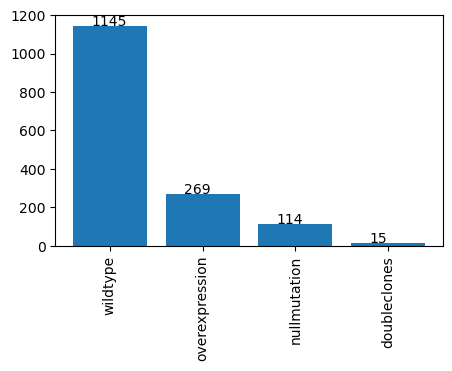

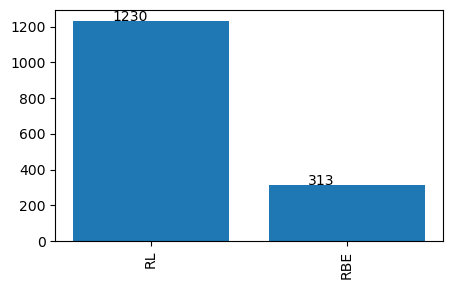

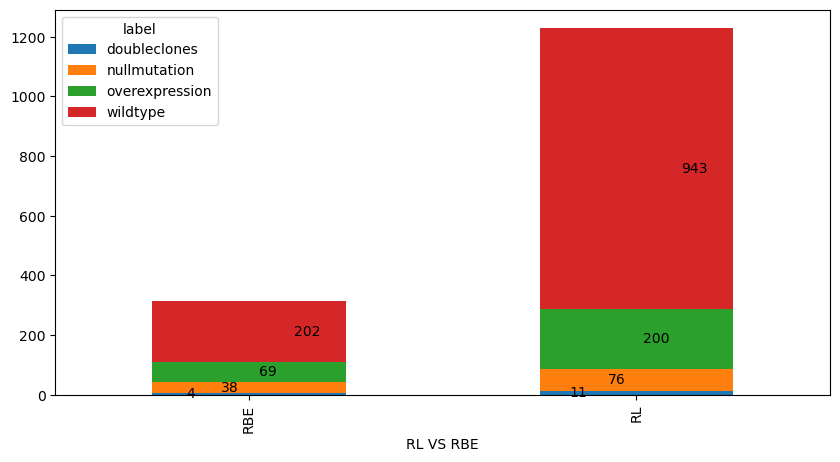

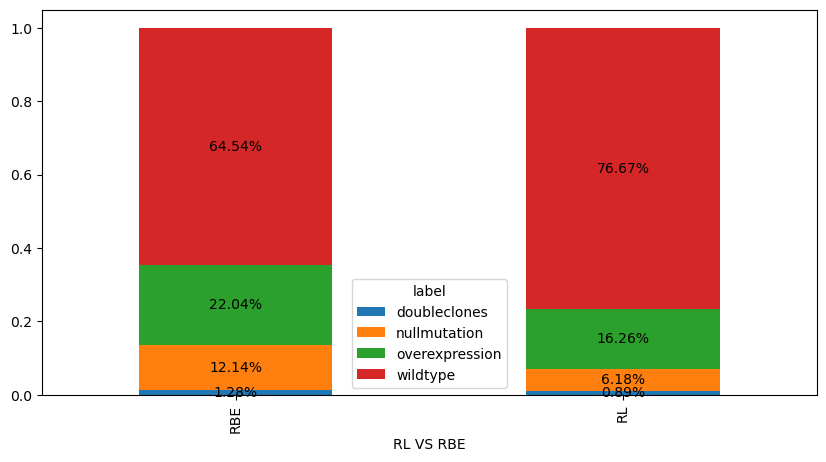

Biopsies with label none: 


,dir,casename,height,width,label,pixels,RL VS RBE,count


In [16]:
if not CREATE_DATASET:
    df = pd.DataFrame.from_dict(biopsies, orient="index")

    # Filter out the "exclude" label biopsies, and the roi groups
    df = df[df["label"] != "exclude"]
    df = df[df["label"].apply(lambda x: "roi" not in x)]

    df["pixels"] = df["height"] * df["width"]

    # Sort by pixels
    df = df.sort_values(by=["pixels"], ascending=False)

    display(df)

    # Show barchart of label, with counts, using plt.bar
    plt.figure(figsize=(5,3))
    plt.bar(df["label"].unique(), df["label"].value_counts())
    plt.xticks(rotation=90)

    # Display counts on top of bars
    for i, v in enumerate(df["label"].value_counts()):
        plt.text(i-0.2, v+1, str(v))
    plt.show()

    def get_first_letters(s):
        """Return every letter before the first non-alpha char. For example: 'RL1' -> 'RL'"""
        for i, c in enumerate(s):
            if not c.isalpha():
                return s[:i]
        return s

    # Count how many RL or RBE numbers there are (in the casename), to make a barchart of that
    df["RL VS RBE"] = df["casename"].apply(lambda x: get_first_letters(x))
    # Group RBET and RBE together
    df["RL VS RBE"] = df["RL VS RBE"].apply(lambda x: "RBE" if x == "RBET" else x)
    plt.figure(figsize=(5,3))
    plt.bar(df["RL VS RBE"].unique(), df["RL VS RBE"].value_counts())
    plt.xticks(rotation=90)

    # Display counts on top of bars
    for i, v in enumerate(df["RL VS RBE"].value_counts()):
        plt.text(i-0.2, v+1, str(v))
    plt.show()


    # Make a stacked barchart of RL VS RBE and label
    df["count"] = 1
    df_stacked = df.groupby(["RL VS RBE", "label"]).sum()
    df_stacked = df_stacked.reset_index()
    df_stacked = df_stacked.pivot(index="RL VS RBE", columns="label", values="count")
    df_stacked = df_stacked.fillna(0)
    df_stacked.plot.bar(stacked=True, figsize=(10,5))
    plt.xticks(rotation=90)

    # Display counts on top of each segment of the bars
    for i, v in enumerate(df_stacked.values.flatten()):
        ncols = len(df_stacked.columns)
        bar_index = i // ncols
        label_index = i % ncols
        x = bar_index + label_index * 0.1
        # Make sure the y value is based on the previous values in the stack of the same bar (so not the other bars)
        y = sum(df_stacked.values.flatten()[bar_index*ncols:bar_index*ncols+i % len(df_stacked.columns)]) + v/2
        plt.text(x-0.15, y, str(int(v)), ha="center", va="center")
    plt.show()


    # Make the same chart but now with percentages
    df_stacked = df_stacked.div(df_stacked.sum(axis=1), axis=0)
    df_stacked.plot.bar(stacked=True, figsize=(10,5))
    plt.xticks(rotation=90)

    # Display percentages on top of each segment of the bars
    for i, v in enumerate(df_stacked.values.flatten()):
        ncols = len(df_stacked.columns)
        bar_index = i // ncols
        label_index = i % ncols
        x = bar_index
        # Make sure the y value is based on the previous values in the stack of the same bar (so not the other bars)
        y = sum(df_stacked.values.flatten()[bar_index*ncols:bar_index*ncols+i % len(df_stacked.columns)]) + v / 2
        plt.text(x, y, f"{v*100:.2f}%", ha="center", va="center")
    plt.show()

    # Display rows with label none
    print("Biopsies with label none: ")
    none_labels = df[df["label"] == "none"]
    # Sort by casename
    none_labels = none_labels.sort_values(by=["casename"])
    # Only unique casenames
    none_labels = none_labels.drop_duplicates(subset=["casename"])
    display(none_labels)

In [11]:
# Write txt file with casenames that have biopsies with label nullmutation or doubleclones
if not CREATE_DATASET:
    # Get all casenames with label nullmutation or doubleclones
    casenames_nullmutation_doubleclones = df[(df["label"] == "nullmutation") | (df["label"] == "doubleclones")]["casename"].unique()
    
    # Sort
    casenames_nullmutation_doubleclones = sorted(casenames_nullmutation_doubleclones)

    with open(os.path.join(LANS_BIOP_ROOT, "casenames_nullmutation_doubleclones.txt"), "w") as f:
        for casename in casenames_nullmutation_doubleclones:
            f.write(f"{casename}\n")

In [ ]:
if not CREATE_DATASET:
    max_size = 9000
    max_size = 128

    # Select cases with height and width < 9000
    small_biopsies = df[(df["height"] < max_size) & (df["width"] < max_size)]

    display(small_biopsies)

    # Same plot as before, but now with small biopsies
    plt.figure(figsize=(5,3))
    plt.bar(small_biopsies["label"].value_counts().keys(), small_biopsies["label"].value_counts())
    plt.xticks(rotation=90)

    for i, v in enumerate(small_biopsies["label"].value_counts()):
        plt.text(i-0.2, v+1, str(v))
    plt.show()

# Create dataset

In [ ]:
spacing = 1.0

CREATE_DATASET = True
if CREATE_DATASET:
    # Iterate through all cases and save the biopsies as pngs
    # Also save a csv with the labels of the biopsies
    destination = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize") # Dir for results
    dest_biop = os.path.join(destination, f"biopsies_s{spacing}") # Dir for biopsy images
    os.makedirs(dest_biop, exist_ok=True)

    biopsy_df = {}
    errors = []

    d = LANS_BIOP_DIR # Dir with biopsies
    print("Dir: ", d)
    for casename in tqdm(casenames):
        casepaths = cases[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        labels = [a.label.name for a in wsa.annotations] # biopsy labels

        outlines = get_outlines(wsa) # biopsy outlines
        try:
            wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
        except Exception as e:
            errors.append((casepaths["wsi"], e))
            continue

        for b in range(len(labels)):
            outline = outlines[b]
            area = get_area(outline, spacing)

            biopsy_name = f"{casename}_b{b}"
            if labels[b] == "none":
                continue
            biopsy_df[biopsy_name] = {
                "dir": d,
                "casename": casename,
                "height": int(area[2]),
                "width": int(area[3]),
                "label": labels[b],
            }

            if os.path.exists(os.path.join(dest_biop, f"{biopsy_name}.png")):
                continue

            # Save biopsy with cv2
            biopsy = wsi.get_patch(*area, spacing)

            # Convert BGR to RGB
            biopsy = cv2.cvtColor(biopsy, cv2.COLOR_BGR2RGB)
            cv2.imwrite(os.path.join(dest_biop, f"{biopsy_name}.png"), biopsy)

    print("Errors: ", len(errors))
    display(errors)

    biopsy_df = pd.DataFrame.from_dict(biopsy_df, orient="index")
    biopsy_df["pixels"] = biopsy_df["height"] * biopsy_df["width"]

    # Save to csv
    biopsy_df.to_csv(os.path.join(destination, f"biopsy_labels_s{spacing}.csv"))

In [ ]:
# Count number of casenames with BIG in it
print("BIG: ", sum([1 for c in casenames if "BIG" in c]))

errors: 19, each and every BIG tiff

 clearly something about the BIG tiffs

# BOLERO

In [6]:
spacing = 1.0

CREATE_DATASET = True
if CREATE_DATASET:
    # Iterate through all cases and save the biopsies as pngs
    # Also save a csv with the labels of the biopsies
    results_dirname = "dataset_fullsize_BOLERO"
    destination = os.path.join(LANS_BIOP_ROOT, results_dirname) # Dir for results
    dest_biop = os.path.join(destination, f"biopsies_s{spacing}") # Dir for biopsy images
    os.makedirs(dest_biop, exist_ok=True)

    biopsy_df = {}
    errors = []

    d = BOLERO_DIR # Dir with biopsies
    print("Dir: ", d)
    for casename in tqdm(casenames_BOLERO):
        casepaths = cases_BOLERO[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        outlines = get_outlines(wsa) # biopsy outlines
        try:
            wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
        except Exception as e:
            errors.append((casepaths["wsi"], e))
            continue

        for b in range(len(outlines)):
            outline = outlines[b]
            area = get_area(outline, spacing)

            biopsy_name = f"{casename}_b{b}"
            biopsy_df[biopsy_name] = {
                "dir": d,
                "casename": casename,
                "height": int(area[2]),
                "width": int(area[3]),
            }

            if os.path.exists(os.path.join(dest_biop, f"{biopsy_name}.png")):
                continue

            # Save biopsy with cv2
            biopsy = wsi.get_patch(*area, spacing)

            # Convert BGR to RGB
            biopsy = cv2.cvtColor(biopsy, cv2.COLOR_BGR2RGB)
            cv2.imwrite(os.path.join(dest_biop, f"{biopsy_name}.png"), biopsy)

    print("Errors: ", len(errors))
    display(errors)

    biopsy_df = pd.DataFrame.from_dict(biopsy_df, orient="index")
    biopsy_df["pixels"] = biopsy_df["height"] * biopsy_df["width"]

    # Save to csv
    biopsy_df.to_csv(os.path.join(destination, f"biopsy_labels_s{spacing}.csv"))


    # Also copy the biopsies to a new folder, and rename them to the number of the row in the csv (so 0.png, 1.png etc.)
    print("spacing: ", spacing)

    # Use the saved csv to make a prepared dataset, with one folder containing all biopsies with names like 0_0.png 1_2.png etc., and a csv with the labels
    # Map each casename to a number
    mapping = {casename: i for i, casename in enumerate(biopsy_df["casename"].unique())}

    # For every file in biopsies_s{spacing}, copy it to biopsies_s{spacing}_anon
    source = os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsies_s{spacing}")
    destination = os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsies_s{spacing}_anon")
    os.makedirs(destination, exist_ok=True)

    # Enumerate over the rows in the csv, NOT the index
    df_clean = biopsy_df.copy().reset_index()
    for i, row in tqdm(df_clean.iterrows(), total=len(biopsy_df)):
        casename = row["casename"]
        # Get the biopsy name
        biopsy_name = row["index"]
        biopsy_nr = int(biopsy_name.split("_b")[-1])
        # Get the source path
        source_path = os.path.join(source, f"{biopsy_name}.png")
        # Get the destination path
        destination_path = os.path.join(destination, f"{mapping[casename]}_{biopsy_nr}.png")
        # Copy the file
        os.system(f'copy "{source_path}" "{destination_path}"')

    # Drop all unnecessary columns, only keeping the index and the label
    df_clean = df_clean.drop(columns=["dir", "casename", "height", "width", "pixels", "index"])

    # Name the index column "id" and then don't save the index
    df_clean.index.name = "id"
    df_clean.to_csv(os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsy_labels_anon_s{spacing}.csv"))

Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\BOLERO\P53 Bolero


100%|██████████| 55/55 [08:46<00:00,  9.57s/it]

Errors:  0


[]

spacing:  1.0


100%|██████████| 226/226 [00:49<00:00,  4.59it/s]


In [15]:
display(mapping)

{'RB0001_P53': 0,
 'RB0002_P53': 1,
 'RB0003_P53': 2,
 'RB0004_P53': 3,
 'RB0005_P53': 4,
 'RB0006_P53': 5,
 'RB0007_P53': 6,
 'RB0008_P53': 7,
 'RB0009_P53': 8,
 'RB0010_P53': 9,
 'RB0011_P53': 10,
 'RB0012_P53': 11,
 'RB0013_P53': 12,
 'RB0014_P53': 13,
 'RB0015_P53': 14,
 'RB0016_P53': 15,
 'RB0017_P53': 16,
 'RB0018_P53': 17,
 'RB0019_P53': 18,
 'RB0020_P53': 19,
 'RB0021_P53': 20,
 'RB0022_P53': 21,
 'RB0023_P53': 22,
 'RB0024_P53': 23,
 'RB0025_P53': 24,
 'RB0026_P53': 25,
 'RB0027_P53': 26,
 'RB0028_P53': 27,
 'RB0029_P53': 28,
 'RB0030_P53': 29,
 'RB0031_P53': 30,
 'RB0032_P53': 31,
 'RB0033_P53': 32,
 'RB0034_P53': 33,
 'RB0035_P53': 34,
 'RB0036_P53': 35,
 'RB0037_P53': 36,
 'RB0038_P53': 37,
 'RB0039_P53': 38,
 'RB0040_P53': 39,
 'RB0041_P53': 40,
 'RB0042_P53': 41,
 'RB0043_P53': 42,
 'RB0044_P53': 43,
 'RB0045_P53': 44,
 'RB0046_P53': 45,
 'RB0047_P53': 46,
 'RB0048_P53': 47,
 'RB0049_P53': 48,
 'RB0050-P53-C2_SME_BIG': 49,
 'RB0051-P53-C3_SME_BIG': 50,
 'RB0052-P53-C4_SME

# PATHXL

In [7]:
# Load labels for pathxl dataset
labels = pd.read_csv(os.path.join(LANS_BIOP_ROOT, 'pathxl_study_slide_labels.csv'))
display(labels.head())
pathxl_case_nrs = labels['case_nr'].to_list()
print(pathxl_case_nrs[:5])
print(len(pathxl_case_nrs))

,case_nr,label,nr_biopsies,nr_raters,concordance %,biopsies
0,RL-0013-1-II-P53,Null,5,4,75,"(NM75,WT100,WT100,WT100,WT100)"
1,RL-0027-I-P53,Double clones,4,4,75,"(WT100,WT100,WT100,DC75)"
2,RL-0036-III-P53,Overexpression,2,4,100,"(OE100,OE100)"
3,RL-0042-III-P53_1,Double clones,4,4,75,"(WT75,DC75,OE100,OE100)"
4,RL-0042-IV-P53_1,Overexpression,4,4,75,"(OE75,WT100,WT100,WT100)"


['RL-0013-1-II-P53', 'RL-0027-I-P53', 'RL-0036-III-P53', 'RL-0042-III-P53_1', 'RL-0042-IV-P53_1']
163


In [31]:
import re

# First we need to go through all XMLs that contain the annotations
for casename in tqdm(casenames_PATHXL):
    casepaths = cases_PATHXL[casename]

    # Open this XML file as text
    with open(casepaths['wsa'], 'r') as f:
        xml = f.read()

    # Look for all name="annotation {number}" in the XML, because we need to check if they're in order
    # Not cap sensitive
    annotations = re.findall(r'name="annotation (\d+)"', xml, re.IGNORECASE) # This will return a list of strings
    annotations = [int(a) for a in annotations] # Convert the strings to integers

    # Check if the annotations are in order
    sorted_annotations = sorted(annotations)
    if annotations != sorted_annotations:
        print(f"Annotations are not in order for {casename}: {annotations}")
    if len(annotations) == 0:
        print(f"No annotations found for {casename}")
        continue
    if annotations[0] != 1:
        print(f"First annotation is not 1 for {casename}: {annotations}")

 24%|██▎       | 38/161 [00:00<00:01, 112.32it/s]

First annotation is not 1 for RL-0264-I-P53: [0]


 58%|█████▊    | 93/161 [00:00<00:00, 90.52it/s] 

No annotations found for RL-0535-I-P53_1
First annotation is not 1 for RL-0584-II-P53: [0, 1]
No annotations found for RL-0595-III-P53


100%|██████████| 161/161 [00:01<00:00, 82.93it/s]


In [29]:
string = 'name="annotation 5"  name="annotation 2"   name="annotation 3"  name="annotation 1"'

annotations = re.findall(r'name="annotation (\d+)"', string, re.IGNORECASE) # This will return a list of strings
print(annotations)

['5', '2', '3', '1']


In [32]:
spacing = 1.0

CREATE_DATASET = True
if CREATE_DATASET:
    # Iterate through all cases and save the biopsies as pngs
    # Also save a csv with the labels of the biopsies
    results_dirname = "dataset_fullsize_PATHXL"
    destination = os.path.join(LANS_BIOP_ROOT, results_dirname) # Dir for results
    dest_biop = os.path.join(destination, f"biopsies_s{spacing}") # Dir for biopsy images
    os.makedirs(dest_biop, exist_ok=True)

    biopsy_df = {}
    errors = []

    d = PATHXL_DIR # Dir with biopsies
    print("Dir: ", d)
    for casename in tqdm(casenames_PATHXL):
        casepaths = cases_PATHXL[casename]
        wsa = WholeSlideAnnotation(casepaths["wsa"])

        labels = [a.label.name for a in wsa.annotations] # biopsy labels
        if len(labels) == 0:
            continue

        outlines = get_outlines(wsa) # biopsy outlines
        try:
            wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
        except Exception as e:
            errors.append((casepaths["wsi"], e))
            continue

        for b in range(len(outlines)):
            outline = outlines[b]
            area = get_area(outline, spacing)

            biopsy_name = f"{casename}_b{b+1}"
            biopsy_df[biopsy_name] = {
                "dir": d,
                "casename": casename,
                "height": int(area[2]),
                "width": int(area[3]),
            }

            if os.path.exists(os.path.join(dest_biop, f"{biopsy_name}.png")):
                continue

            # Save biopsy with cv2
            biopsy = wsi.get_patch(*area, spacing)

            # Convert BGR to RGB
            biopsy = cv2.cvtColor(biopsy, cv2.COLOR_BGR2RGB)
            cv2.imwrite(os.path.join(dest_biop, f"{biopsy_name}.png"), biopsy)

    print("Errors: ", len(errors))
    display(errors)

    biopsy_df = pd.DataFrame.from_dict(biopsy_df, orient="index")
    biopsy_df["pixels"] = biopsy_df["height"] * biopsy_df["width"]

    # Save to csv
    biopsy_df.to_csv(os.path.join(destination, f"biopsy_labels_s{spacing}.csv"))


    # Also copy the biopsies to a new folder, and rename them to the number of the row in the csv (so 0.png, 1.png etc.)
    print("spacing: ", spacing)

    # Use the saved csv to make a prepared dataset, with one folder containing all biopsies with names like 0_0.png 1_2.png etc., and a csv with the labels
    # Map each casename to a number
    mapping = {casename: i for i, casename in enumerate(biopsy_df["casename"].unique())}

    # For every file in biopsies_s{spacing}, copy it to biopsies_s{spacing}_anon
    source = os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsies_s{spacing}")
    destination = os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsies_s{spacing}_anon")
    os.makedirs(destination, exist_ok=True)

    # Enumerate over the rows in the csv, NOT the index
    df_clean = biopsy_df.copy().reset_index()
    for i, row in tqdm(df_clean.iterrows(), total=len(biopsy_df)):
        casename = row["casename"]
        # Get the biopsy name
        biopsy_name = row["index"]
        biopsy_nr = int(biopsy_name.split("_b")[-1])
        # Get the source path
        source_path = os.path.join(source, f"{biopsy_name}.png")
        # Get the destination path
        destination_path = os.path.join(destination, f"{mapping[casename]}_{biopsy_nr}.png")
        # Copy the file
        os.system(f'copy "{source_path}" "{destination_path}"')

    # Drop all unnecessary columns, only keeping the index and the label
    df_clean = df_clean.drop(columns=["dir", "casename", "height", "width", "pixels", "index"])

    # Name the index column "id" and then don't save the index
    df_clean.index.name = "id"
    df_clean.to_csv(os.path.join(LANS_BIOP_ROOT, results_dirname, f"biopsy_labels_anon_s{spacing}.csv"))

Dir:  L:\\basic\\divg\\PATH-COMPAI\\datasets\\Barrett\\p53_experiment_luuk_biopsy-level_no-HE\final_test_set_(low_consensus_second_look)\not_ready\pathxl


  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [32:09<00:00, 11.98s/it]

Errors:  1


[('L:\\\\basic\\\\divg\\\\PATH-COMPAI\\\\datasets\\\\Barrett\\\\p53_experiment_luuk_biopsy-level_no-HE\\final_test_set_(low_consensus_second_look)\\not_ready\\pathxl\\RL-0345-P53-1.tiff',
  wholeslidedata.image.backend.UnsupportedVendorError("Image: 'L:\\\\basic\\\\divg\\\\PATH-COMPAI\\\\datasets\\\\Barrett\\\\p53_experiment_luuk_biopsy-level_no-HE\\final_test_set_(low_consensus_second_look)\\not_ready\\pathxl\\RL-0345-P53-1.tiff', with properties: <_PropertyMap {'openslide.level-count': '9', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '62976', 'openslide.level[0].tile-height': '512', 'openslide.level[0].tile-width': '512', 'openslide.level[0].width': '159232', 'openslide.level[1].downsample': '2', 'openslide.level[1].height': '31488', 'openslide.level[1].tile-height': '512', 'openslide.level[1].tile-width': '512', 'openslide.level[1].width': '79616', 'openslide.level[2].downsample': '4', 'openslide.level[2].height': '15744', 'openslide.level[2].tile-height': '51

spacing:  1.0


100%|██████████| 628/628 [02:44<00:00,  3.83it/s]


# Prepare data

In [ ]:
mapping = {
    "wildtype": 0,
    "overexpression": 1,
    "nullmutation": 2,
    "doubleclones": 3,
    "none": -1,
}

In [ ]:
if CREATE_DATASET:
    # Iterate through csv that was just created, and map the labels to numbers
    # Also copy the biopsies to a new folder, and rename them to the number of the row in the csv (so 0.png, 1.png etc.)
    print("spacing: ", spacing)

    # Use the saved csv to make a prepared dataset, with one folder containing all biopsies with names like 0.png 1.png etc., and a csv with the labels
    # Open the csv
    df = pd.read_csv(os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsy_labels_s{spacing}.csv"), index_col=0)

    # For every file in biopsies_s4.0, copy it to biopsies_s4.0_anon, and rename it to the number of the row in the csv (so 0.png, 1.png etc.) (NOT the index)
    source = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsies_s{spacing}")
    destination = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsies_s{spacing}_anon")
    os.makedirs(destination, exist_ok=True)

    # Enumerate over the rows in the csv, NOT the index
    df_clean = df.copy().reset_index()
    for i, row in tqdm(df_clean.iterrows(), total=len(df)):
        # Get the biopsy name
        biopsy_name = row["index"]
        # Get the label
        label = row["label"]
        # Get the source path
        source_path = os.path.join(source, f"{biopsy_name}.png")
        # Get the destination path
        destination_path = os.path.join(destination, f"{i}.png")
        # Copy the file
        os.system(f'copy "{source_path}" "{destination_path}"')

    # Drop all unnecessary columns, only keeping the index and the label
    df_clean = df_clean.drop(columns=["dir", "casename", "height", "width", "pixels", "index"])

    # Map labels to numbers according to the mapping:
    df_clean["label"] = df_clean["label"].map(mapping)
    # It should be an integer
    df_clean["label"] = df_clean["label"].astype(int)

    # Name the index column "id" and then don't save the index
    df_clean.index.name = "id"
    df_clean.to_csv(os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsy_labels_anon_s{spacing}.csv"))

In [ ]:
destination = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"biopsies_s{spacing}_anon")
saved = set(sorted([int(f.split('.')[0]) for f in os.listdir(destination)]))

# Check for missing files
required = set(range(len(df)))
missing = list(required.difference(saved))
# Give each row of df a number as index, because right now it's the biopsy name
df_numeric_index = df.reset_index()
print("Missing: ", df_numeric_index.loc[missing])

# Patch data

not using this; do this during or just before training

In [ ]:
# Example of patching
spacing = 2.0

d = LANS_BIOP_DIR
casename = casenames[0]
print(casename)
casepaths = cases[casename]
outlines = get_outlines(WholeSlideAnnotation(casepaths["wsa"])) # biopsy outlines
area = get_area(outlines[0], spacing) # biopsy area
sub_areas = get_sub_areas(area) # sub areas (patches) of biopsy area
wsi = WholeSlideImage(casepaths["wsi"]) # whole slide image
plot_sub_areas(wsi, sub_areas, show_emptiness=True)

In [ ]:
# We want to split each biopsy into patches of 256x256, and give them a label according to the biopsy label
# The patches should be saved in a folder called patches_s{spacing}_anon, with names like 0.png, 1.png etc.
# The labels should be saved in a csv called patches_s{spacing}_anon.csv
# The csv should have the following columns: id, label
# The id should be the number of the patch (so 0, 1 etc.)
# The label should be a number according to the mapping above (so 0, 1, 2, 3 for wildtype, overexpression, nullmutation, doubleclones respectively)
spacing = 2.0

# CREATE_DATASET = True
if CREATE_DATASET:
    # Iterate through all cases and save patches of the biopsies as pngs
    # Also save a csv with the labels of the patches
    errors = []

    destination_dir = os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"patches_s{spacing}_anon")
    os.makedirs(destination_dir, exist_ok=True)

    patch_labels = {}

    ctr = 0
    # Iterate through every case
    for casename in tqdm(casenames):
        # Get the casepaths
        casepaths = cases[casename]
        # Get the wsa
        wsa = WholeSlideAnnotation(casepaths["wsa"])
        # Get the labels
        labels = [a.label.name for a in wsa.annotations]
        # Get the outlines
        outlines = get_outlines(wsa)
        # Get the wsi
        try:
            wsi = WholeSlideImage(casepaths["wsi"])
        except Exception as e:
            errors.append((casepaths["wsi"], e))
            continue

        # Iterate through every biopsy
        for b in range(len(labels)):
            # Get the outline
            outline = outlines[b]
            # Get the area
            area = get_area(outline, spacing)
            # Get the sub areas
            sub_areas = get_sub_areas(area)
            # Flatten the sub areas
            sub_areas = [a for sub_area in sub_areas for a in sub_area]
            # Get the label
            label = labels[b]
            if label == "none":
                continue

            # Iterate through every sub area
            for i, sub_area in enumerate(sub_areas):
                # Get the patch
                patch = wsi.get_patch(*sub_area, spacing)
                # Get the destination path
                destination_path = os.path.join(destination_dir, f"{ctr}.png")
                # Save the patch in RGB format
                cv2.imwrite(destination_path, patch[...,::-1])
                # Add the label to the patch_labels dict
                patch_labels[ctr] = mapping[label]
                # Increment the counter
                ctr += 1

    patch_labels = pd.DataFrame.from_dict(patch_labels, orient="index")
    patch_labels.index.name = "id"
    patch_labels.columns = ["label"]
    patch_labels.to_csv(os.path.join(LANS_BIOP_ROOT, "dataset_fullsize", f"patches_s{spacing}_anon.csv"))